## Hiragana Character Recognition with Keras and OpenCV 
In today's notebook we will be working with a dataset from the National Diet Library (NDL Lab) that contains 73 drawn hiragana characters. This dataset contains 80000 data samples in which we will use to train and evaluate our own hiragana recognition application. The most common dataset used for character recognition/classification type problems is called the MNIST dataset in which the goal is to classify handwritten digits as a number between 0 and 9. Although this dataset is quite useful I thought it would be interesting to try my hand at hiragana classification! We hope you find this exercise in character recognition interesting! 


Dataset Info/Location:
https://lab.ndl.go.jp/cms/hiragana73

## Import Relevant Libraries 
First, lets import the relevant libraries.

In [1]:
## For Data Paths 
from pathlib import Path

## General Python Libraries 
import numpy as np
import pandas as pd 

## Image Processing 
import cv2

## Visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Data Processing 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


## Keras 
import os
os.environ['KERAS_BACKEND'] = 'theano'
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


## Data Extraction 
For this tutorial the dataset can be downloaded from this link and unzipped to your directory of choice: 
https://lab.ndl.go.jp/cms/hiragana73

Be sure to specify the datapath variable below to the folder hiragana73. 

In [2]:
datapath = Path('.../hiragana73') 

In addition, I created a csv file called Hiragana Key which contains basic info about the dataset. It tells us about the character, what folder these data samples are located in, and how many samples of this type exist. Lets read this file in with the read_csv function. 

In [3]:
labels = pd.read_csv('HiraganaKey.csv')

In [4]:
labels

,文字,ディレクトリ,画像数
0,あ,U3042,"1,208"
1,い,U3044,"1,122"
2,う,U3046,"1,148"
3,え,U3048,"1,077"
4,お,U304A,"1,283"
5,か,U304B,"1,259"
6,が,U304C,"1,200"
7,き,U304D,"1,121"
8,ぎ,U304E,"1,091"
9,く,U304F,"1,266"


For the next section we will create a dataframe that contains our image locations and our labels.  

In [5]:
##Create empty object 
files_df= []


## For every folder in our specified data path
for folderName in os.listdir(datapath):
    imgs_path = datapath / folderName
    imgs = sorted(imgs_path.glob('*.png'))
    
## Map Directory to Column 1, Map Label to Column 2 
    for name in imgs:
        files_df.append((str(name),str(labels['文字'].values[labels['ディレクトリ'] == folderName])))
        
## Change Column Names to Image(1) and Label(2)        
files_df = pd.DataFrame(files_df, columns=['Image', 'Label'], index=None)    

files_df looks perfect now and ready to go. 

In [6]:
files_df.head()

,Image,Label
0,/Users/steimel64/Desktop/Machine Learning/Upda...,['あ']
1,/Users/steimel64/Desktop/Machine Learning/Upda...,['あ']
2,/Users/steimel64/Desktop/Machine Learning/Upda...,['あ']
3,/Users/steimel64/Desktop/Machine Learning/Upda...,['あ']
4,/Users/steimel64/Desktop/Machine Learning/Upda...,['あ']


Lets use the sample function to randomize table since it was in order previously. Looks like we have 80000 hiragana characters. 

In [7]:
files_df = files_df.sample(frac=1.,random_state=42).reset_index(drop=True)

In [8]:
print("Total number of Hiragana Characters: ", len(files_df))

Total number of Hiragana Characters:  80000


## Visualization of Hiragana Character 
Lets take a look at one random character and see what it looks like. We can do this by using the opencv imread function, lets import the file at index 10, and set the second parameter to 0 (gray scale). We can then plot the character which seems to be ぶ (bu).

Label- ['ぶ']
Image Shape- (48, 48)


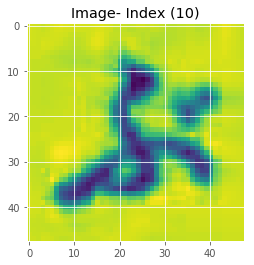

In [9]:
testchar = cv2.imread(files_df['Image'][10],0)
plt.imshow(testchar)
print('Label-',files_df['Label'][10])
print('Image Shape-',testchar.shape)
plt.title('Image- Index (10)')
plt.show()

Lets now plot this image as a Dataframe. This is how a computer typically sees an image and we can clearly see that each number indicates an pixel value (intensity) from 0-255. Values closer to 255 would indicate a white space while values closer to 0 would indicate darker space. 

In [10]:
## Parameters for Pandas Data Frame 
pd.options.display.max_rows = 48
pd.options.display.max_columns = 48

## Visualize Dataframe 
pd.DataFrame(testchar)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,238,236,235,233,235,238,240,241,240,239,238,238,237,237,238,239,240,238,236,234,234,233,232,233,235,235,234,235,234,232,230,229,229,230,230,232,230,229,228,229,233,236,239,243,241,238,235,233
1,238,236,235,234,235,237,239,239,238,237,236,236,236,236,238,240,240,237,235,231,231,231,229,229,230,230,230,232,232,230,229,229,229,230,230,232,231,229,229,230,233,236,239,243,241,238,235,233
2,237,236,235,235,236,237,238,237,236,234,233,233,234,236,239,242,241,237,233,232,232,233,233,231,230,229,230,228,228,227,227,228,229,230,230,233,232,231,230,231,234,237,239,243,241,238,235,233
3,237,236,235,237,237,237,237,236,234,232,231,230,233,236,241,243,241,236,232,231,232,235,238,237,232,229,230,225,225,226,227,228,229,230,231,234,233,232,232,233,235,237,239,242,240,238,235,233
4,236,236,235,239,238,238,236,235,233,231,230,230,232,236,241,243,241,235,230,227,225,229,237,238,232,228,228,223,224,226,227,229,230,231,232,235,235,234,234,235,236,238,239,241,240,238,235,234
5,235,235,235,238,237,236,234,232,231,230,229,229,231,234,238,240,237,231,226,228,220,219,230,237,234,230,231,224,226,228,230,231,233,233,233,236,236,236,236,236,237,238,239,241,240,237,235,234
6,235,235,235,235,234,232,230,229,228,227,227,227,228,231,233,234,231,226,221,224,208,200,210,223,226,227,230,227,228,230,232,234,235,235,234,237,237,237,237,238,238,239,239,241,239,237,235,234
7,235,235,235,232,231,229,228,226,225,225,225,226,226,227,229,230,227,222,217,214,191,177,187,203,211,215,221,228,230,232,234,236,236,236,235,238,238,238,238,238,238,239,239,240,239,237,235,234
8,233,232,232,232,232,230,229,227,225,224,223,225,224,223,226,229,228,223,219,209,166,147,163,167,197,199,220,224,231,231,232,240,237,234,240,237,239,240,239,237,236,238,240,238,238,237,236,235
9,233,232,232,232,231,231,229,228,227,226,226,228,227,226,228,227,222,214,206,215,168,133,123,105,131,137,161,191,212,223,226,234,236,235,240,237,237,236,235,235,235,237,238,238,238,237,236,235


## Data Pre-Processing
Its time for everyones favorite part of Machine Learning! Today we will work with Data Pre-Processing so that our image data works with our Keras Convolutional Neural Network (CNN) model. 
Steps:
* Lets first assign our labels to the y data frame. 
* Lets extract all 80000 hiragana characters from the files_df links
* Reshape the values to a vector of 2304 ()
* Append the characters to a new dataframe 
* Convert to Array 

#### Assign All Y Values to new array.

In [11]:
y = files_df['Label']

#### Read All Characters 

In [12]:
dataframe = []

## Function for extraction 
for i in range(80000):
    character = cv2.imread(files_df['Image'][i],0)
    character = character.reshape(2304)
    dataframe.append(character)

In [13]:
charfeatures = np.array(dataframe)

Lets check these array shapes. As we can see our we have an array of 80000 by 2304 (48x48) for the features and an array of 80000 for the y (target) values. Perfect!

In [14]:
charfeatures.shape

(80000, 2304)

In [15]:
y.shape

(80000,)

#### Encode Labels and Create Dictionary References 
Next we will be using the LabelEncoder from SKlearn which allows us to encode our target values as integer values. This is important so that our neural network can accept our inputs. 
Also we need to create a dictionary of values so that we can reference these numbers and find our actual character value in the future. This dictionary value is printed below. 

In [16]:
encoder = LabelEncoder()

encoder.fit_transform(y)

encoder_character_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

print(encoder_character_mapping)

y_encoded = encoder.fit_transform(y)

{"['あ']": 0, "['い']": 1, "['う']": 2, "['え']": 3, "['お']": 4, "['か']": 5, "['が']": 6, "['き']": 7, "['ぎ']": 8, "['く']": 9, "['ぐ']": 10, "['け']": 11, "['げ']": 12, "['こ']": 13, "['ご']": 14, "['さ']": 15, "['ざ']": 16, "['し']": 17, "['じ']": 18, "['す']": 19, "['ず']": 20, "['せ']": 21, "['ぜ']": 22, "['そ']": 23, "['ぞ']": 24, "['た']": 25, "['だ']": 26, "['ち']": 27, "['ぢ']": 28, "['つ']": 29, "['づ']": 30, "['て']": 31, "['で']": 32, "['と']": 33, "['ど']": 34, "['な']": 35, "['に']": 36, "['ぬ']": 37, "['ね']": 38, "['の']": 39, "['は']": 40, "['ば']": 41, "['ぱ']": 42, "['ひ']": 43, "['び']": 44, "['ぴ']": 45, "['ふ']": 46, "['ぶ']": 47, "['ぷ']": 48, "['へ']": 49, "['べ']": 50, "['ぺ']": 51, "['ほ']": 52, "['ぼ']": 53, "['ぽ']": 54, "['ま']": 55, "['み']": 56, "['む']": 57, "['め']": 58, "['も']": 59, "['や']": 60, "['ゆ']": 61, "['よ']": 62, "['ら']": 63, "['り']": 64, "['る']": 65, "['れ']": 66, "['ろ']": 67, "['わ']": 68, "['ゐ']": 69, "['ゑ']": 70, "['を']": 71, "['ん']": 72}


#### Split Train and Test Set
In Machine Learning, it is always important to split the training data and test data before creating any models. The Training data is used to train our Neural Network while our test data is used to validate the models performance. In this case we will have a test set of 16000 hiragana characters and a training set of 64000 characters. 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(charfeatures, y_encoded, test_size=0.20, random_state=42, stratify=y_encoded)
y_backup = y_test

In [18]:
print(X_train.shape)
print(X_test.shape)

(64000, 2304)
(16000, 2304)


Now we need to reshape these arrays into our actual image shapes which is 48 x 48 x 1. 

In [19]:
X_train = X_train.reshape(X_train.shape[0], 48, 48,1)
X_test = X_test.reshape(X_test.shape[0], 48, 48,1)

Lets convert the x values to float (integer) so we can perform division on them. 

In [20]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Divide all pixel values by 255 which scales values between 0 and 1 for ease of processing. 

In [21]:
X_train /= 255
X_test /= 255

Convert our y (label) values to 73 categorical values for our model output. 

In [22]:
y_train = ks.utils.to_categorical(y_train, 73)
y_test = ks.utils.to_categorical(y_test, 73)

#### CNN Architecture 

A Convolutional Neural Network is one of the state of the art neural networks now used for computer vision. In this tutorial we will build a quick CNN architecture with Keras and see if we can accurately detect which hiragana we are seeing! 

This network contains the following Layers: 

In [23]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(73, activation='softmax'))

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16928)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2166912   
_________________________________________________________________
dense_2 (Dense)              (None, 73)                9417      
Total params: 2,176,649
Trainable params: 2,176,649
Non-trainable params: 0
_________________________________________________________________


We can then use the compile function to specify things like our loss function, optimizer, and accuracy metrics which are important parameters to drive the training process. 

In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

Training a model is as simple as calling the models fit function. We specify the X_Train, and y_train values as well as 5 epochs (Iterations on entire dataset).

In [26]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
64000/64000 [==============================] - 112s 2ms/step - loss: 1.6115 - acc: 0.5999
Epoch 2/5
64000/64000 [==============================] - 112s 2ms/step - loss: 0.3034 - acc: 0.9201
Epoch 3/5
64000/64000 [==============================] - 112s 2ms/step - loss: 0.2241 - acc: 0.9407
Epoch 4/5
64000/64000 [==============================] - 112s 2ms/step - loss: 0.1891 - acc: 0.9490
Epoch 5/5
64000/64000 [==============================] - 113s 2ms/step - loss: 0.1675 - acc: 0.9555


We can now evaluate our model with the evaluate function. It returns the loss values and respective accuracy of the model. It looks like our model scored an accuracy of around 95 % on the training set and 96 % on the test set. Not Bad! 

In [27]:
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=128)
print(loss_and_metrics)

16000/16000 [==============================] - 13s 792us/step
[0.15093438039720058, 0.9606875]


With the predict_classes function we can use our trained model to create predictions based on the test set which can be seen below. It looks like our characters are written as integers though which isnt very useful right now. 

In [32]:
predictions = model.predict_classes(X_test)
pred = list(predictions)
actual = list(y_backup)
pd.DataFrame({'Actual':actual,'Predictions':pred})[0:10]

,Actual,Predictions
0,66,66
1,7,7
2,19,19
3,69,69
4,63,63
5,72,72
6,55,55
7,60,60
8,24,24
9,33,33


The below two functions reference our dictionary mappings to convert our integer values back to the actual characters. Good Thing we decided to make that dictionary mapping from the start. 

In [34]:
Predictions = []
for i in pred: 
    character = list(encoder_character_mapping.keys())[list(encoder_character_mapping.values()).index(i)]
    Predictions.append(character)

In [35]:
Actual = []
for i in actual: 
    character = list(encoder_character_mapping.keys())[list(encoder_character_mapping.values()).index(i)]
    Actual.append(character)

Lets see what our first few characters are now which should be the same values as above but with actual characters. Looks like the code works as planned! 

In [36]:
results = pd.DataFrame({'Actual': Actual, 'Predictions': Predictions})
results[0:10]

,Actual,Predictions
0,['れ'],['れ']
1,['き'],['き']
2,['す'],['す']
3,['ゐ'],['ゐ']
4,['ら'],['ら']
5,['ん'],['ん']
6,['ま'],['ま']
7,['や'],['や']
8,['ぞ'],['ぞ']
9,['と'],['と']


## Plotting some Characters 
I also decided to plot 10 characters that are correct and 10 that are incorrect to validate that everything is working alright. It looks like our model is seeing exactly as it should be in most cases! 

本当の字 ['れ']
予想の字 ['れ']


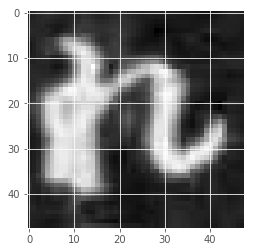

本当の字 ['き']
予想の字 ['き']


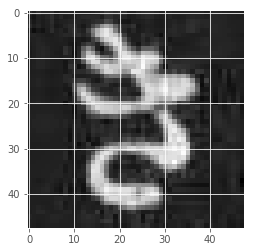

本当の字 ['す']
予想の字 ['す']


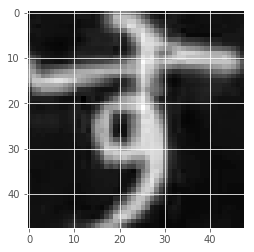

本当の字 ['ゐ']
予想の字 ['ゐ']


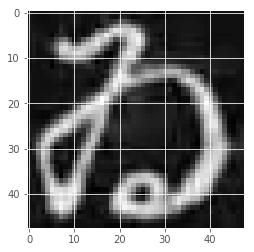

本当の字 ['ら']
予想の字 ['ら']


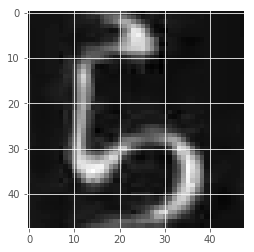

本当の字 ['ん']
予想の字 ['ん']


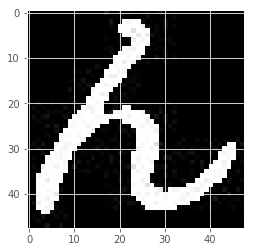

本当の字 ['ま']
予想の字 ['ま']


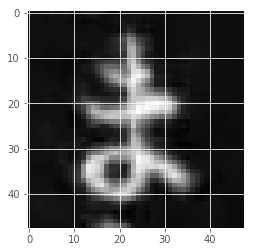

本当の字 ['や']
予想の字 ['や']


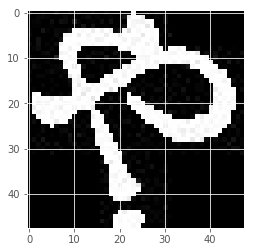

本当の字 ['ぞ']
予想の字 ['ぞ']


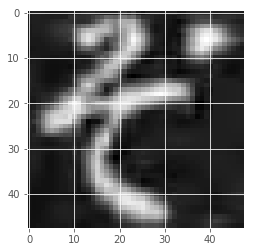

本当の字 ['と']
予想の字 ['と']


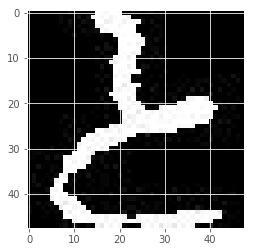

In [37]:
import matplotlib 
for i in range(10):
    test_character = X_test[i]
    test_character_image = test_character.reshape(48,48)
    plt.imshow(test_character_image, cmap = matplotlib.cm.binary,
           interpolation='nearest')
    print('本当の字',Actual[i])
    print('予想の字',Predictions[i])
    plt.show()

#### Lets check our mistakes 

We take the below steps again to only filter to the error predictions. 
After checking mistakes it looks like alot of our values actually make sense. 
Characters like pi and bi hi and re po and bo are actually pretty similar which the model was not able to distinguish well. 

In [38]:
errors = results[results['Actual'] != results['Predictions']]
errors[0:10]

,Actual,Predictions
23,['だ'],['た']
58,['ぴ'],['び']
69,['ひ'],['れ']
79,['ぜ'],['せ']
115,['り'],['ま']
120,['ぽ'],['ぼ']
122,['ぽ'],['ぼ']
124,['ぴ'],['び']
128,['ぴ'],['び']
132,['ぽ'],['ぼ']


本当の字 ['だ']
予想の字 ['た']


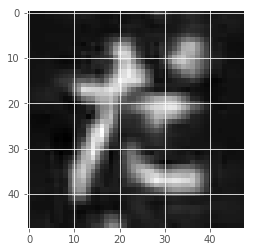

本当の字 ['ぴ']
予想の字 ['び']


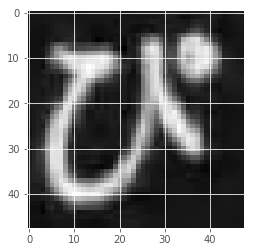

本当の字 ['ひ']
予想の字 ['れ']


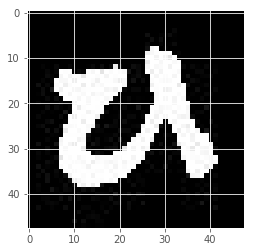

本当の字 ['ぜ']
予想の字 ['せ']


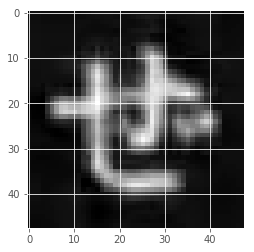

本当の字 ['り']
予想の字 ['ま']


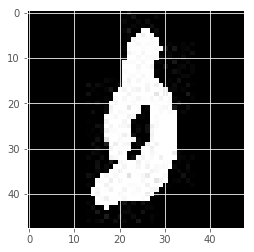

本当の字 ['ぽ']
予想の字 ['ぼ']


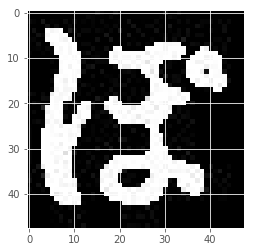

本当の字 ['ぽ']
予想の字 ['ぼ']


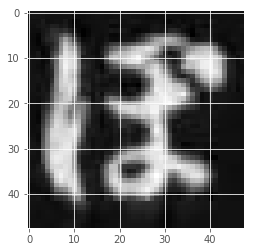

本当の字 ['ぴ']
予想の字 ['び']


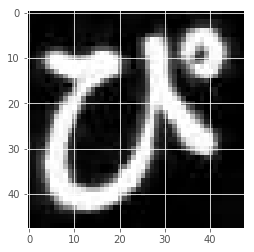

本当の字 ['ぴ']
予想の字 ['び']


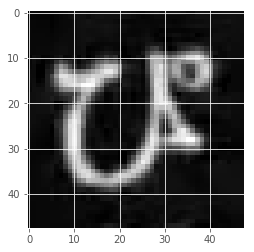

本当の字 ['ぽ']
予想の字 ['ぼ']


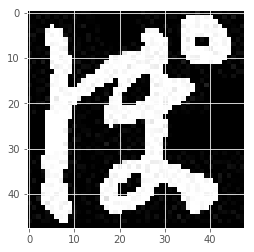

In [39]:
indexes = list(errors[0:10].index)

for i in indexes:
    test_character = X_test[i]
    test_character_image = test_character.reshape(48,48)
    plt.imshow(test_character_image, cmap = matplotlib.cm.binary,
           interpolation='nearest')
    print('本当の字',errors['Actual'][i])
    print('予想の字',errors['Predictions'][i])
    plt.show()

## Conclusion

This dataset is truly fun to play with and a nice change from the standard MNIST we are all used to using for image classification tasks. I learned how to pre-process and extract image data and was able to create a CNN model with around 96 % accuracy to predict Hiragana Characters. 